# intro

This notebook will (for the Barents Sea)

- do a month by month breakdown of the volume distribution given in the layers package
- decompose G terms to make sure these are budgeted and plotted
- attempt to avoid hard coding

This was initially done in April of 2025, this needs to be redone in September of 2025 to get up to the correct gates/check if this was correctly done (likely not). Next will need to see if we can get advection from the advective term.

# load the packages and files

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta

In [2]:
import h5py
from scipy.io import loadmat
from scipy.io import savemat

In [3]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [4]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/Layers/figs/"
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/"
dirrun = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirState = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [5]:
# define the basin, the index and the years we want to look at
nbasin = "BarentsS"
iB = 6  # for the maskBasin
ffac = 1e-6

In [6]:
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0

# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2007"] = np.arange(2,13,1)
times["2008"] = np.arange(1,2,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps

11

In [7]:
layers_path

'/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/'

# load the TS bins

In [8]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
print(nT)

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
print(nS)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
print(binwidthT.shape)
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

112
112
(112,)


# Test masking

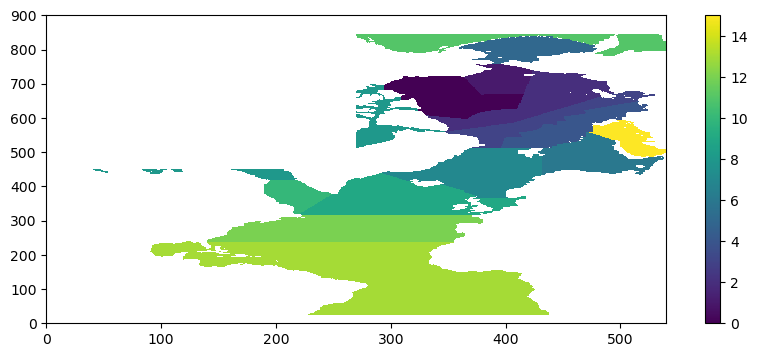

In [9]:
# define the Barents Sea up to the NZRU opening
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)


ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [13]:
# DEFINITIONS FOR WHOLE BARENTS SEA
ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
ind2d = mskBasin.reshape(364500)                 # the flattened basin
ind2d_wet = ind2d[iwetC2d]                       # labels in the flattened array that are wet
iwet_BarentsS2D = np.where(ind2d_wet == iB)[0]   # labels in the wet points that are the basin

# DEFINITIONS FOR JUST THE SMALL MASK
barton_mask = np.load("poly_mask.npy")
iwet_Bartonmsk = np.where(barton_mask == 1)[0]

# DEFINITIONS FOR THE NORTH OF THE BARENTS SEA

In [14]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
print("RAC2d",rac2d.shape)
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")
hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]
rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))

RAC2d (146614,)
(4833023,)


In [15]:
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

test = np.full(mskBasin.shape,np.nan)
test[y_bso,x_bso] = 1
test[y_sfj,x_sfj] = 2
test[y_fjnz,x_fjnz] = 3
test[y_nzru,x_nzru] = 4

# load the files for volume distribution

In [16]:
# DO NOT RUN IF ALREADY CALCULATED
vol_distrib = {}
vol_distrib[nbasin] = {}
dT,dS = np.meshgrid(binwidthT,binwidthS)
bindices = iwet_BarentsS2D   # not sure if this is the best way to index probably fix layer
bindices = iwet_Bartonmsk

# try to read the volume from the layers
for i,j in zip(tsstr,datetimes):
    print(i)
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_p_" + str(LwetC2d) + "." + i + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS)*(nT),0) # 0 here is for matlab translation

    tmp = np.reshape(tmp,(nT,nS,LwetC2d))              # LwetC2d x nS x nT
    small = rac2d * hf2d
    small = np.tile(small[np.newaxis,np.newaxis,:],(nT,nS,1))

    tmp = tmp * small * ffac

    # do the summing over volume
    tmp1 = np.nansum(tmp[:,:,bindices],axis=2)
    tmp1[tmp1 == 0] = np.nan
    vol_distrib[nbasin][i] = tmp1 / dT / dS  # [m^3 / (degC psu)]

del tmp1

0000267408
0000271440
0000275904
0000280224
0000284688
0000289008
0000293472
0000297936
0000302256
0000306720
0000311040
0000315504


In [18]:
# save the volume distribution
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
np.savez_compressed(matpath + "vol_distrib_barton_mask.npz", **vol_distrib[nbasin])
print("Saved vol_distrib as .npz")

Saved vol_distrib as .npz


In [19]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
# loaded = np.load(matpath + "vol_distrib_BarentsS.npz", allow_pickle=True)
loaded = np.load(matpath + "vol_distrib_barton_mask.npz", allow_pickle=True)
vol_distrib = dict(loaded)
# vol_distrib

# now plot the volume distributions in T-S space to see and save as figure

In [20]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [21]:
# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


0000267408
0000271440
0000275904
0000280224
0000284688
0000289008
0000293472
0000297936
0000302256
0000306720
0000311040
0000315504


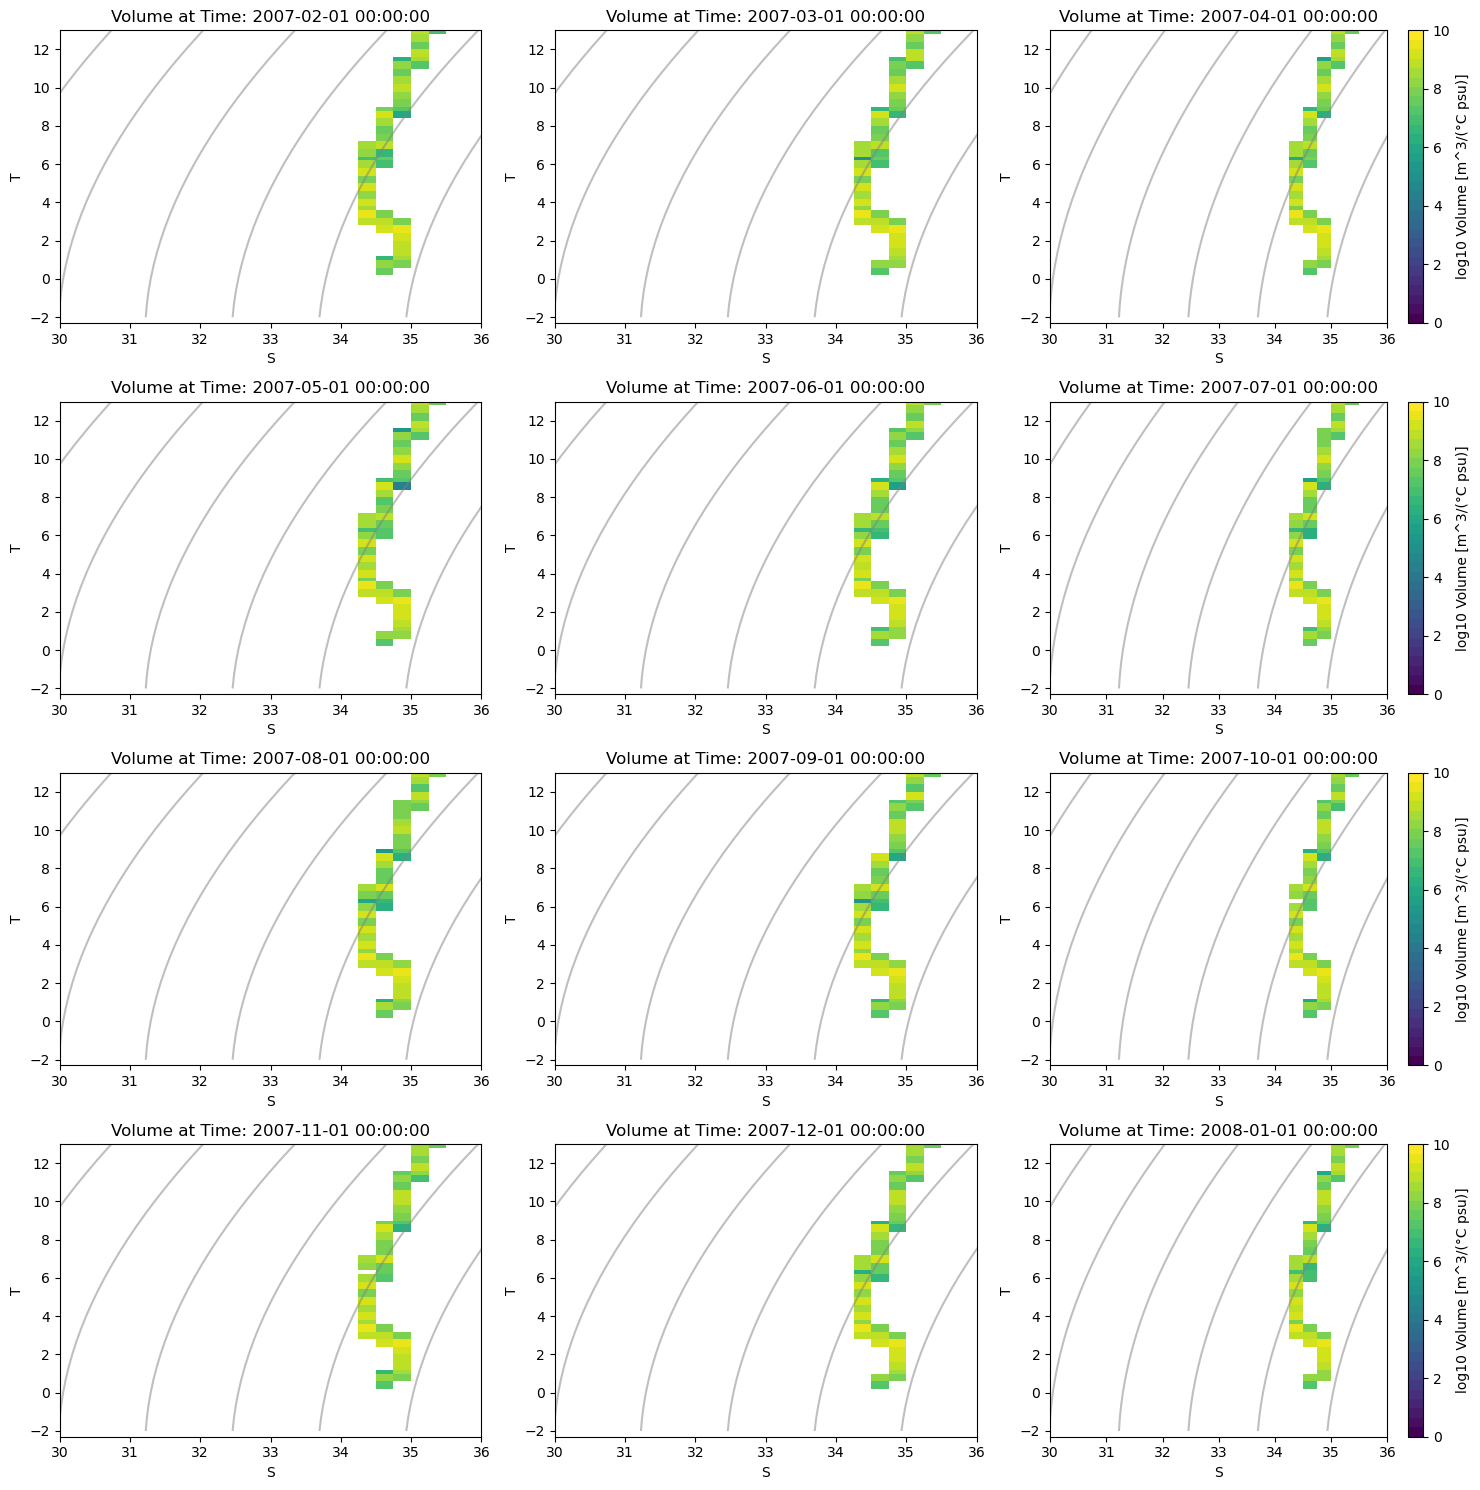

In [22]:
# setup before the run
xlims, ylims = np.array([30, 36]), np.array([-2.3, 13])

# setup the plotting
fig, axes = plt.subplots(4,3, figsize = (15,15))
axes = axes.flatten()

# loop through tsstr and plot each
i = 0  # for getting the datetimes name
for idx, ts in enumerate(tsstr):
    print(ts)
    ax = axes[idx]
    im = ax.pcolormesh(Sbin,Tbin, np.log10(vol_distrib[ts]).T,cmap=cmap2,vmin=0,vmax=10)

    ax.set_xlabel("S")
    ax.set_ylabel("T")
    ax.set_title(f"Volume at Time: {datetimes[i]}")
    #ax.grid()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Add colorbar for the last row of subplots
    if idx % 3 == 2 or idx == len(tsstr) - 1:
        cbar = fig.colorbar(im, ax=ax, orientation='vertical')
        cbar.set_label("log10 Volume [m^3/(°C psu)]")

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    i += 1

# remove unused subplots
for i in range(len(tsstr),len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig(imgpath + "monthly_volume_distribution.png",dpi=300)

# now return to the G terms and see if we can calculate and understand these

In [18]:
# try to run with all months

In [19]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(dirrun + "diags/LAYERS/layers_3d_Ttend." + tsstr[0] + ".meta")
metaS=parsemeta(dirrun + "diags/LAYERS/layers_3d_Stend." + tsstr[0] + ".meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]

In [20]:
# metaT['fldList']  # 0, 1, 2, 7, 
metaS['fldList']   # 13, 14, 15, 16, 19, 22
a = metaS['fldList']
print(a[12],a[13],a[14],a[19],a[20],a[23])  # these are the ifldS values
# these are the total tend due to salt terms, tend due to salt surf forcing, tend due to salt horizontal diff, tend due to salt vertical diff
# ... tend due to salt horiz adv, tend due to salt vertical adv
ifldS = np.array([12,13,14,19,20,23])  # total tend, surf, hDiff, vDiff, hADV, vADV

LaSs1SLT LaSh1SLT LaSz1SLT LSha1SLT LSza1SLT LSto1SLT


In [21]:
metaT['fldList']   # 13, 14, 15, 16, 19, 22
a = metaT['fldList']
print(a[0],a[1],a[2],a[7],a[8],a[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

LaTs2TH LaTh2TH LaTz2TH LTha2TH LTza2TH LTto2TH


In [22]:
setTtend=np.array(nFldsT.copy())
setStend=np.array(nFldsS.copy())

In [23]:
print(setTtend[ifldT])
print()
print(setTtend)
print()
# print(setStend[ifldS])
for i in range(len(ifldT)-1, -1, -1):
    print(i)
    print(setTtend[ifldT[i]])

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']

['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'TzKp2TH' 'TzRe2TH' 'TzBg2TH' 'TKpg2TH'
 'LTha2TH' 'LTza2TH' 'LTBh2TH' 'LTBz2TH' 'LTto2TH' 'LaTs1SLT' 'LaTh1SLT'
 'LaTz1SLT' 'TzKp1SLT' 'TzRe1SLT' 'TzBg1SLT' 'TKpg1SLT' 'LTha1SLT'
 'LTza1SLT' 'LTBh1SLT' 'LTBz1SLT' 'LTto1SLT']

5
LTto2TH
4
LTza2TH
3
LTha2TH
2
LaTz2TH
1
LaTh2TH
0
LaTs2TH


In [ ]:
# make the G_T term
G_T = {}
G_T[nbasin] = {}
    
# now loop through each timestep in tsstr
for t in tsstr:
    print(t)
    # initialize for the timestep
    G_T[nbasin][t] = {}
    residT = None

    # loop through each ifldT backward (total tend, vADV, hADV, vDiff, hDiff, surface)
    for i in range(len(ifldT)-1, -1, -1):
        # read from the file for current timestep
        tmp = read_float32_skip(dirrun + f"diags/LAYERS/layers_3d_Ttend.{t}.data", nx*ny*(nT-1), ifldT[i])
        tmp = np.reshape(tmp,(nT-1,nx*ny))

        # apply masking and rescale with ffac
        tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac

        # update residual
        if i == ifldT.shape[0]-1:  # for total tendency, leave as is
            residT = tmp
        else:                      # for all other terms, remove from the residual
            residT = residT-tmp
    
        # just do the Barents Sea for this one
        a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
        G_T[nbasin][t][setTtend[ifldT[i]]] = a

    # compute and store the residual for this timestep
    G_T[nbasin][t]["residT"] = np.nansum(residT[:,iwet_BarentsS2D],axis=1)

In [ ]:
# save G_T to file
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
np.savez_compressed(matpath + "G_T_BarentsS.npz", **G_T[nbasin])
print("Saved vol_distrib as .npz")

In [ ]:
print(setStend[ifldS])
print()
print(setStend)
print()
# print(setStend[ifldS])
for i in range(len(ifldS)-1, -1, -1):
    print(i)
    print(setStend[ifldS[i]])

In [ ]:
# make the G_S term
# this loop will be different because terms in different order (i=0) will be the total tend
G_S = {}
G_S[nbasin] = {}

# loop through the timesteps as above
for t in tsstr:
    print(t)
    # initialize for the timestep
    G_S[nbasin][t] = {}
    residS = None

    # now loop through similar to ifldS -  change the looping because total tend is at the end
    for i in range(len(ifldS)-1, -1, -1):
        # read the file
        tmp = read_float32_skip(dirrun + f"diags/LAYERS/layers_3d_Stend.{t}.data", nx*ny*(nT-1),ifldS[i])
        tmp = np.reshape(tmp,(nS-1,nx*ny))

        # apply masking
        tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac

        # update the terms
        if i == ifldS.shape[0]-1:
            residS = tmp          # for total tendency
        else:
            residS = residS-tmp   # for all other terms, remove from residual
    
        # just do for the Barents Sea
        a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
        G_S[nbasin][t][setStend[ifldS[i]]] = a
    
    # loop through again to calculate resid
    G_S[nbasin][t]["residS"] = np.nansum(residS[:,iwet_BarentsS2D],axis=1)  # check if this axis is correct

In [ ]:
# save G_S to file
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
G_S_array = {key: np.array(value) for key, value in G_S[nbasin].items()}
np.savez_compressed(matpath + "G_S_BarentsS.npz", **G_S_array)
print("Saved vol_distrib as .npz")

# load these G terms from file to prove that we can do that

In [ ]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "G_S_BarentsS.npz", allow_pickle=True)
# G_S = dict(loaded)
G_S = {key: loaded[key].item() for key in loaded}
G_S[mytime].keys()

In [ ]:
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
loaded = np.load(matpath + "G_T_BarentsS.npz", allow_pickle=True)
G_T = {key: loaded[key].item() for key in loaded}
G_T[mytime].keys()

In [ ]:
tsstr[10]
mytime = tsstr[9]

In [ ]:
# get the indices we want to plot - only need one sample array
sampleS = G_S[mytime]['LSto1SLT']
nonzer_indices = np.flatnonzero(sampleS)
ibegS = nonzer_indices[0]
iendS = nonzer_indices[-1]
iiS = np.arange(ibegS-5,iendS+5)

# do same index sampling for G_T
sampleT = G_T[mytime]['LTto2TH']
nonzer_indices = np.flatnonzero(sampleT)
ibegT = nonzer_indices[0]
iendT = nonzer_indices[-1]
iiT = np.arange(ibegT-1,iendT+2)

print(iiS.shape,iiT.shape)
iiS

In [ ]:
# plot all the available times

# Loop through the first 24 keys of G_T
for i, mytime in enumerate(list(G_T.keys())[:24]):
    fig = plt.figure(figsize=(9, 5))

    ax1 = plt.subplot(121)
    ax1.plot(binmidS[iiS], G_S[mytime]["LSto1SLT"][iiS], 'b-', alpha=0.5, label="tot")
    ax1.plot(binmidS[iiS], G_S[mytime]["LSza1SLT"][iiS] + G_S[mytime]["LSha1SLT"][iiS], 'r-', alpha=0.5, label="adv")
    ax1.plot(binmidS[iiS], G_S[mytime]["LaSz1SLT"][iiS] + G_S[mytime]["LaSh1SLT"][iiS], 'g-', alpha=0.5, label="diff")
    ax1.plot(binmidS[iiS], G_S[mytime]["LaSs1SLT"][iiS], 'c-', alpha=0.5, label="surf")
    ax1.plot(binmidS[iiS], G_S[mytime]["residS"][iiS], 'k-', alpha=0.5, label="resid")
    ax1.legend(loc="best")
    ax1.set_title(f"G_S - {mytime}")
    ax1.set_ylabel('Resid G_S [Sv]')


    ax2 = plt.subplot(122)
    ax2.plot(binmidT[iiT], G_T[mytime]["LTto2TH"][iiT], 'b-', alpha=0.5, label="tot")
    ax2.plot(binmidT[iiT], G_T[mytime]["LTza2TH"][iiT] + G_T[mytime]["LTha2TH"][iiT], 'r-', alpha=0.5, label="adv")
    ax2.plot(binmidT[iiT], G_T[mytime]["LaTz2TH"][iiT] + G_T[mytime]["LaTh2TH"][iiT], 'g-', alpha=0.5, label="diff")
    ax2.plot(binmidT[iiT], G_T[mytime]["LaTs2TH"][iiT], 'c-', alpha=0.5, label="surf")
    ax2.plot(binmidT[iiT], G_T[mytime]["residT"][iiT], 'k-', alpha=0.5, label="resid")
    ax2.legend(loc="best")
    ax2.set_title(f"G_T - {mytime}")
    ax2.set_ylabel('Resid G_T [Sv]')


    plt.tight_layout()


    # save each figure to show An
    plt.savefig(imgpath + "monthly_G_terms_" + mytime+ ".png",dpi=300)
    
    plt.show()

# double checking that this is closed

In [ ]:
fig = plt.figure(figsize = (9,5))

ax = plt.subplot(121)
ax.plot(binmidS[iiS], G_S[mytime]["LSto1SLT"][iiS], 'b-', alpha=0.5,label="tot")
ax.plot(binmidS[iiS], G_S[mytime]["LSza1SLT"][iiS] + G_S[mytime]["LSha1SLT"][iiS], 'r-', alpha=0.5,label="adv")
ax.plot(binmidS[iiS], G_S[mytime]["LaSz1SLT"][iiS] + G_S[mytime]["LaSh1SLT"][iiS], 'g-', alpha=0.5,label="diff")
ax.plot(binmidS[iiS], G_S[mytime]["LaSs1SLT"][iiS], 'c-', alpha=0.5,label="surf")
ax.plot(binmidS[iiS], G_S[mytime]["residS"][iiS], 'k-', alpha=0.5,label="resid")
ax.legend(loc="best")
ax.set_title("G_S")


ax = plt.subplot(122)
ax.plot(binmidT[iiT], (G_T[mytime]["LTto2TH"][iiT]), 'b-', alpha=0.5,label="tot")
ax.plot(binmidT[iiT], G_T[mytime]["LTza2TH"][iiT] + G_T[mytime]["LTha2TH"][iiT], 'r-', alpha=0.5,label="adv")
ax.plot(binmidT[iiT], G_T[mytime]["LaTz2TH"][iiT] + G_T[mytime]["LaTh2TH"][iiT], 'g-', alpha=0.5,label="diff")
ax.plot(binmidT[iiT], G_T[mytime]["LaTs2TH"][iiT], 'c-', alpha=0.5,label="surf")
ax.plot(binmidT[iiT], G_T[mytime]["residT"][iiT], 'k-', alpha=0.5,label="resid")
ax.legend(loc="best")
ax.set_title("G_T")

In [ ]:
a = G_S[mytime]["LSto1SLT"]
b = G_S[mytime]["LSza1SLT"] + G_S[mytime]["LSha1SLT"]
c = G_S[mytime]["LaSz1SLT"] + G_S[mytime]["LaSh1SLT"]
d = G_S[mytime]["LaSs1SLT"]
e = G_S[mytime]["residS"]

# now try to make the J terms for one month

In [17]:
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend.0000723024.meta")

# set 1 - the total terms we want for the budget
setTS_Ttend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Ttend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set2_146614.0000315504.meta")["fldList"]

# set 1 - the total terms for the salt budget
setTS_Stend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Stend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set2_146614.0000315504.meta")["fldList"]

In [18]:
setTS_Ttend

['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'LTha_TS', 'LTza_TS', 'LTto_TS']

In [19]:
setTS_Stend

['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'LSha_TS', 'LSza_TS', 'LSto_TS']

In [ ]:
# do the Jy term
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy[nbasin] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)
small = rac2d * hf2d

# loop through the existing timesteps
for t in tsstr:
    print(t)
    Jy[nbasin][t] = {}
    Jy[nbasin][t]['G_T'] = {}
    
    # now loop through the terms and add these to the dictionary
    for i in range(len(setTS_Ttend)-1, -1, -1):
        print(i)
        # read the file and apply masking
        filename = dirrun + f"diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_{LwetC2d}.{t}.data"
        tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
        tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
        tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac
    
        # if at end of loop
        if i == len(setTS_Ttend)-1:
            f = (np.nansum(tmp, axis=2))
            f = np.nansum(f * binwidthS1)
    
        # double check the names in the listed file
        if i == len(setTS_Ttend)-1:
            # do not remove from the residual - this is the total tendency
            residT = tmp
        elif i in {0,1,2,3,4}:
            # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
            # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
            residT -= tmp
    
        tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
        # TEST:
        # tmp1 = tmp1.T
        tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
        Jy[nbasin][t][setTS_Ttend[i]] = tmp1
        Jy[nbasin][t]['G_T'][setTS_Ttend[i]] = tmp2
        del tmp
        del tmp1
        del tmp2


    myresid = np.nansum(residT[:,:,iwet_BarentsS2D],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # myresid = myresid.T
    Jy[nbasin][t]["residT"] = myresid
    Jy[nbasin][t]["G_T"]["residT"] = np.nansum(Jy[nbasin][t]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

    print()
# set units and labels
Jy["unit"] = "m/s/psu"

# Define your filename
filename = "Jy_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Save the dictionary
np.savez(matpath + filename, **Jy)

In [19]:
# Load the .npz file
filename = "Jy_data.npz"
filename = "Jy_data_full.npz"

matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jy_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jy_loaded

In [20]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
Jx = {}
Jx[nbasin] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

# loop through the existing timesteps
for t in tsstr:
    print(t)
    Jx[nbasin][t] = {}
    Jx[nbasin][t]['G_S'] = {}

    # loop through the diagnostics
    for i in range(len(setTS_Stend)-1, -1, -1):
        filename = dirrun + f"diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_{LwetC2d}.{t}.data"
        tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
        tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
        print(tmp.shape)
    
        small = rac2d * hf2d
        tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac
    
        if i == len(setTS_Stend)-1:
            # LSto_TS - total tendency
            residS = tmp
        elif i in {0,1,2,3,4}:
            # LaSs_TS LaSh_TS LaSz_TS LSha_TS LSza_TS LSBh_TS
            # surface, hdiff, vdiff, hADV, vADV, hADV bolus
            residS -= tmp
    
        # use stri_wet, strb is names of basins
        tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # should be of shape nS-1, nT-1
        # TEST
        # tmp1 = tmp1.T
        thisbinwidthT1 = np.tile(binwidthT1[:,np.newaxis],(1, nS - 1))
        tmp2 = np.nansum(tmp1 * thisbinwidthT1, axis=1)                 # second dim is T because this is S tend
        Jx[nbasin][t][setTS_Stend[i]] = tmp1
        Jx[nbasin][t]['G_S'][setTS_Stend[i]] = tmp2
        del tmp
        del tmp1
        del tmp2

    tmp1 = np.nansum(residS[:,:,iwet_BarentsS2D],axis=2)    # sum over geo space
    mytileT1 = np.tile(binwidthT1[np.newaxis,:],(nS-1,1))  # nS-1 x nT-1
    tmp2 = np.nansum(tmp1 * mytileT1, axis=0)     # sum over T ( dimension 0)
    Jx[nbasin][t]["residS"] = tmp1    # should be of shape nS-1, nT-1
    Jx[nbasin][t]["G_S"]["residS"] = tmp2 #should be of shape nT-1

# set units and labels
Jx["descr"] = "m/s/degC"

# Define your filename
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Save the dictionary
np.savez(matpath + filename, **Jx)

0000267408
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000271440
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000275904
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000280224
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000284688
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000289008
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000293472
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
0000297936
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)


In [40]:
# Define your filename
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Load the .npz file
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
Jx_loaded[nbasin].keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

# load Jy from previous and plot in 2D to see if we did it

In [20]:
# load the old Jy terms for one month to plot as a comparison
# Load the .npz file
filename = "Jy_data_full.npz"

matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jy_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jy_loaded

# Define your filename
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Load the .npz file
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jx_loaded

In [21]:
Jy_loaded['BarentsS'].keys()

dict_keys(['0000267408', '0000271440', '0000275904', '0000280224', '0000284688', '0000289008', '0000293472', '0000297936', '0000302256', '0000306720', '0000311040', '0000315504'])

Text(0.5, 1.0, 'total tend (calculated)')

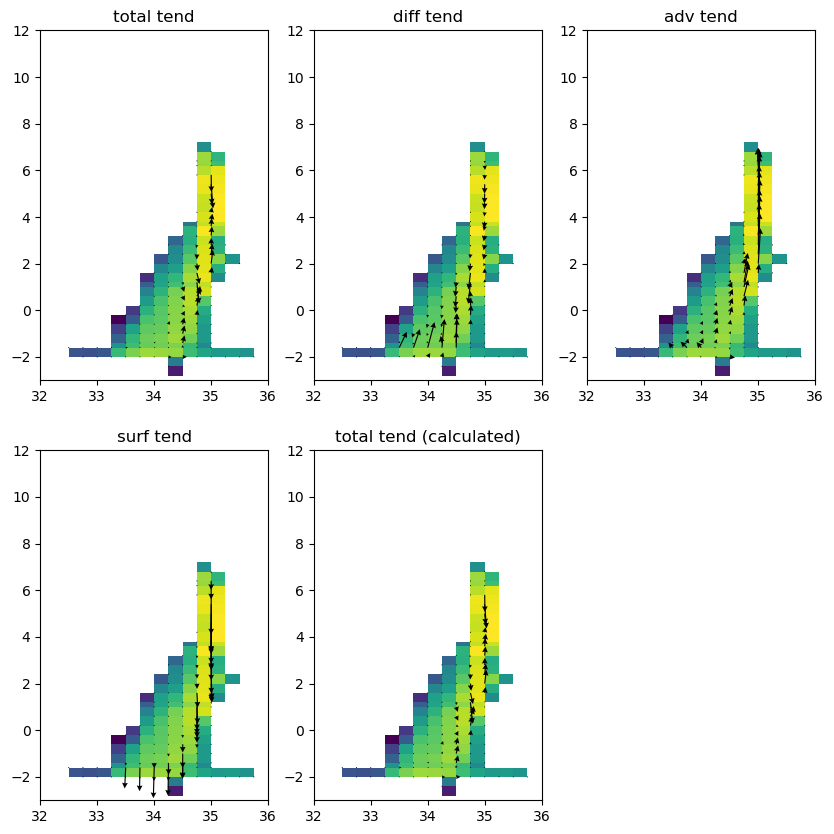

In [107]:
fig = plt.figure(figsize = (10,10))
mytime = '0000275904'


# first subplot - total tendency
ax = plt.subplot(231)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[mytime]).T)
# set the quivers
U1,V1 = Jx_loaded[nbasin][mytime]['LSto_TS'].T, Jy_loaded[nbasin][mytime]['LTto_TS'].T
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U1, V1, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("total tend")

# second subplot - adv tendency
ax = plt.subplot(232)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[mytime]).T)
# set the quivers
U1,V1 = Jx_loaded[nbasin][mytime]['LaSz_TS'].T + Jx_loaded[nbasin][mytime]['LaSh_TS'].T, Jy_loaded[nbasin][mytime]['LaTz_TS'].T + Jy_loaded[nbasin][mytime]['LaTh_TS'].T
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U1, V1, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("diff tend")

# third subplot - adv tendency
ax = plt.subplot(233)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[mytime]).T)
# set the quivers
U2,V2 = Jx_loaded[nbasin][mytime]['LSza_TS'].T + Jx_loaded[nbasin][mytime]['LSha_TS'].T, Jy_loaded[nbasin][mytime]['LTza_TS'].T + Jy_loaded[nbasin][mytime]['LTha_TS'].T
U2[U2 == 0], V2[V2 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U2, V2, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("adv tend")

# third subplot - adv tendency
ax = plt.subplot(234)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[mytime]).T)
# set the quivers
U3,V3 = Jx_loaded[nbasin][mytime]['LaSs_TS'].T, Jy_loaded[nbasin][mytime]['LaTs_TS'].T
U3[U3 == 0], V3[V3 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U3, V3, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("surf tend")

# third subplot - total
ax = plt.subplot(235)
ax.pcolormesh(Sbin,Tbin,np.log10(vol_distrib[mytime]).T)
# set the quivers
U4 = U1 + U2 + U3
V4 = V1 + V2 + V3
q = ax.quiver(Sbin2, Tbin2, U4, V4, width=0.005, zorder=3, headwidth=5,scale=1e2)
ax.set_xlim(32,36)
ax.set_ylim(-3,12)
ax.set_title("total tend (calculated)")

# plt.savefig(imgpath + "test_tendencies_" + tsstr[0] + ".png",dpi=300)

## Try to compare this to the gate transports for the same period to see if we did it

In [30]:
# we made the gates ealier but we need to set the directionality of these as in try_Mterm
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
    
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1
    
choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [31]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)
num_years = len(allyears)

## Maybe we try and create the gate transports here from this run to see if we did it wrong

In [58]:
dirIn

'/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/BUDG/'

In [32]:
# not sure if I don't want to load from these?

loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advheat_2025_09.npy", allow_pickle=True).item()
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]  # psu.m^3/s

loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_advslt_2025_09.npy", allow_pickle=True).item()
salt_transport_timeseries = loaded_data["salt_transport_timeseries"]  # degC.m^3/s

# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data.npy", allow_pickle=True).item()

# Access the saved dictionaries
theta_timeseries = loaded_data["theta_timeseries"]   # degC
salt_timeseries = loaded_data["salt_timeseries"]     # PSU
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]  # binning index
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]    # binning index

In [39]:

# To load later
loaded_data = np.load("/scratch2/mmurakami/aste_270x450x180/ASTER1/timeseries_data_0914.npy", allow_pickle=True).item()

# Access the saved dictionaries
heat_transport_timeseries = loaded_data["heat_transport_timeseries"]
salt_transport_timeseries = loaded_data["salt_transport_timeseries"]
theta_timeseries = loaded_data["theta_timeseries"]
salt_timeseries = loaded_data["salt_timeseries"]
binned_theta_timeseries = loaded_data["binned_theta_timeseries"]
binned_salt_timeseries = loaded_data["binned_salt_timeseries"]

In [40]:
# check with one of these if we need to redo these with head and salt full for this run?

In [41]:
# we have confirmed that this run is the same output as ASTE

In [82]:
# now to try and show that this gate convergence fits with previous solution
def m_TS_from_prebinned(heat_tr, salt_tr, iT, iS, Tcent, Scent, binwidthT, binwidthS,
                        T_min=1e-3, S_min=1e-4):
    """
    Inputs:
      heat_tr : (nz, nfaces)  degC·m^3/s  (T*Q)
      salt_tr : (nz, nfaces)  psu·m^3/s   (S*Q)
      iT, iS  : (nz, nfaces)  integer bin indices in [0..nT-1],[0..nS-1]
      Tcent   : (nT,)         bin centers (degC)
      Scent   : (nS,)         bin centers (psu)
    Output:
      m_TS    : (nS, nT)      Sv/(psu·°C)
    """
    nT = len(Tcent); nS = len(Scent)
    m_TS = np.zeros((nS-1, nT-1), dtype=float)

    # Flatten
    HT  = heat_tr.reshape(-1)              # degC·m^3/s
    ST  = salt_tr.reshape(-1)              # psu·m^3/s
    iTf = iT.reshape(-1).astype(int)
    iSf = iS.reshape(-1).astype(int)

    # Valid bins
    valid = (iTf >= 0) & (iTf < nT) & (iSf >= 0) & (iSf < nS)
    if not np.any(valid):
        return m_TS

    iTv = iTf[valid]; iSv = iSf[valid]
    HTv = HT[valid];  STv = ST[valid]

    # Get bin-center T,S for those indices
    Tv = Tcent[iTv]; Sv = Scent[iSv]

    # Recover Q (m^3/s). Prefer salt (often better conditioned), fallback to heat.
    Qs = np.where(np.abs(Sv) > S_min, STv / Sv, np.nan)
    Qt = np.where(np.abs(Tv) > T_min, HTv / Tv, np.nan)
    Q  = np.where(np.isfinite(Qs), Qs, Qt)
    Q  = np.where(np.isfinite(Q), Q, 0.0)   # m^3/s (+ into basin)

    # Convert to Sv and normalize by ΔS·ΔT → Sv/(psu·°C)
    dSv = binwidthS[iSv]; dTv = binwidthT[iTv]
    contrib = (Q * 1e-6) / (dSv * dTv)

    np.add.at(m_TS, (iSv, iTv), contrib)
    return m_TS

In [83]:
# Bin metadata
binsT_edges = binsTH_edges            # len = nT+1
binsS_edges = binsSLT_edges           # len = nS+1
binwidthT   = binsT_edges[1:] - binsT_edges[:-1]   # (nT,)
binwidthS   = binsS_edges[1:] - binsS_edges[:-1]   # (nS,)
Tcent       = 0.5 * (binsT_edges[1:] + binsT_edges[:-1])  # (nT,)
Scent       = 0.5 * (binsS_edges[1:] + binsS_edges[:-1])  # (nS,)

In [84]:
# ta = theta_timeseries['BSO'][4][2]
# sa = salt_timeseries['BSO'][4][2]

# plt.scatter(sa,ta)
# plt.xlim(33,36)

In [85]:
heat_transport_timeseries['BSO'].shape

(1, 12, 50, 63)

In [86]:
np.nanmax(binned_theta_timeseries['BSO'][0][2])

25.0

In [102]:
binsTH_edges.shape

(113,)

In [90]:
year_idx  = 0    # example
month_idx = 2    # example March 2007
gates = ["BSO", "SFJ", "FJNZ", "NZRU"]

m_by_gate = {}
Jx_by_gate = {}
Jy_by_gate = {}

for g in gates:
    # property transports (T*Q, S*Q) and *pre-binned indices* (ints)
    HT = heat_transport_timeseries[g][year_idx, month_idx]           # (nz, nfaces)
    ST = salt_transport_timeseries[g][year_idx, month_idx]           # (nz, nfaces)
    iT = binned_theta_timeseries[g][year_idx, month_idx]             # (nz, nfaces) ints
    iS = binned_salt_timeseries[g][year_idx, month_idx]              # (nz, nfaces) ints

    m_gate = m_TS_from_prebinned(HT, ST, iT, iS, Tcent, Scent, binwidthT, binwidthS)
    m_by_gate[g] = m_gate                                            # Sv/(psu·°C)

    # Diagnostic J (Convention A): Jx = ∫ m dS, Jy = 0
    Jx = np.cumsum(m_gate * binwidthS[1:, None], axis=0)              # Sv/°C
    Jy = np.zeros_like(Jx)                                           # Sv/psu
    Jx_by_gate[g], Jy_by_gate[g] = Jx, Jy

# Total gate term for the budget:
m_TS_total = sum(m_by_gate[g] for g in gates)                        # Sv/(psu·°C)

In [91]:
def compute_gradient_manual(data_s, data_t, spacing_s, spacing_t):
    # Gradient for salinity along axis 0
    gradient_s = np.zeros_like(data_s)
    gradient_s[1:-1] = (data_s[2:] - data_s[:-2]) / (spacing_s[2:] + spacing_s[:-2])
    gradient_s[0] = (data_s[1] - data_s[0]) / spacing_s[1]  # forward difference at start
    gradient_s[-1] = (data_s[-1] - data_s[-2]) / spacing_s[-1]  # backward difference at end

    # Gradient for temperature along axis 1
    gradient_t = np.zeros_like(data_t)
    gradient_t[:, 1:-1] = (data_t[:, 2:] - data_t[:, :-2]) / (spacing_t[:, 2:] + spacing_t[:, :-2])
    gradient_t[:, 0] = (data_t[:, 1] - data_t[:, 0]) / spacing_t[:, 1]  # forward difference at start
    gradient_t[:, -1] = (data_t[:, -1] - data_t[:, -2]) / spacing_t[:, -1]  # backward difference at end

    return gradient_s, gradient_t

In [92]:
# choose the time
mytime = '0000275904'
a = binmidTp[:,0].reshape(111)
a.shape
b = binmidSp[:,0].reshape(111)
b.shape

binwidthTtile = np.tile(a[np.newaxis,:],(nS-1,1))
binwidthStile = np.tile(b[:,np.newaxis],(1,nT-1))


# compute the gradients based on the layers
# overall tendency
J_S_div, J_T_div = compute_gradient_manual(Jx_loaded[nbasin][mytime]['LSto_TS'].T, Jy_loaded[nbasin][mytime]['LTto_TS'].T, binwidthStile, binwidthTtile)
div_J = J_S_div + J_T_div

# advective tend (should be able to be ignored by the gates)
J_S_div, J_T_div = compute_gradient_manual(Jx_loaded[nbasin][mytime]['LSza_TS'].T + Jx_loaded[nbasin][mytime]['LSha_TS'].T, Jy_loaded[nbasin][mytime]['LTza_TS'].T + Jy_loaded[nbasin][mytime]['LTha_TS'].T, binwidthStile, binwidthTtile)
div_Ja = J_S_div + J_T_div

# diffusive tend
J_S_div, J_T_div = compute_gradient_manual(Jx_loaded[nbasin][mytime]['LaSz_TS'].T + Jx_loaded[nbasin][mytime]['LaSh_TS'].T, Jy_loaded[nbasin][mytime]['LaTz_TS'].T + Jy_loaded[nbasin][mytime]['LaTh_TS'].T, binwidthStile, binwidthTtile)
div_Jd = J_S_div + J_T_div

# surface tend
J_S_div, J_T_div = compute_gradient_manual(Jx_loaded[nbasin][mytime]['LaSs_TS'].T, Jy_loaded[nbasin][mytime]['LaTs_TS'].T, binwidthStile, binwidthTtile)
div_Jsurf = J_S_div + J_T_div


(-2.0, 9.0)

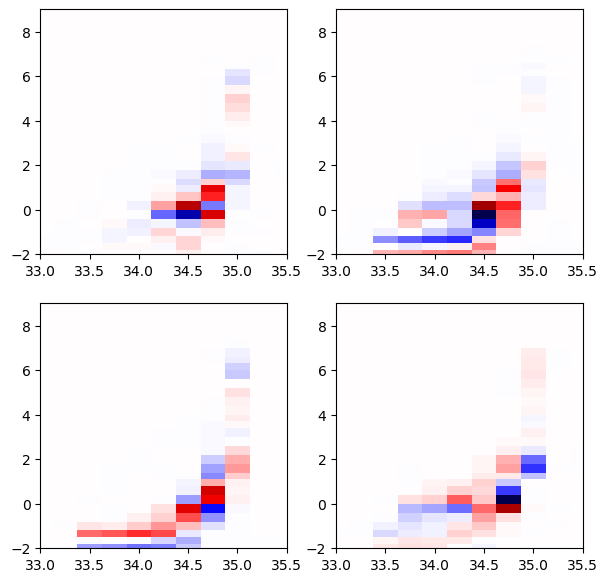

In [101]:
fig = plt.figure(figsize=(7,7))

ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jd),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jsurf),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(224)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Ja),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

(-2.0, 9.0)

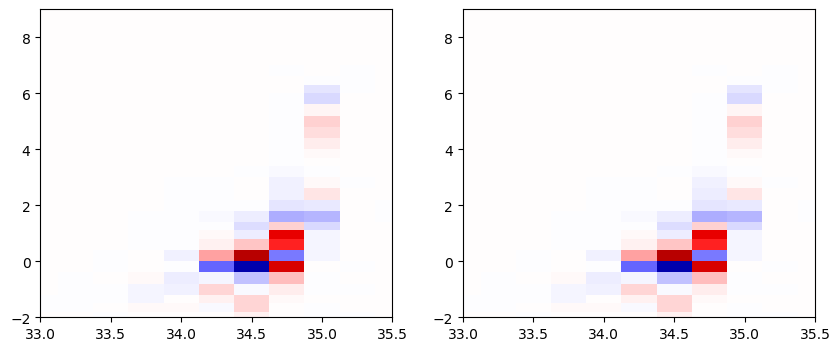

In [118]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(122)
a = m_TS_total
b = div_Ja - m_TS_total
cb = ax.pcolormesh(Sbin2,Tbin2,(-(div_Jd + div_Jsurf + (a+b))),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

In [114]:
print(np.nansum(div_Jd + div_Jsurf + div_Ja))

-14.081530109177498


In [115]:
print(np.nansum(div_J))

-14.064826757128086


(-2.0, 9.0)

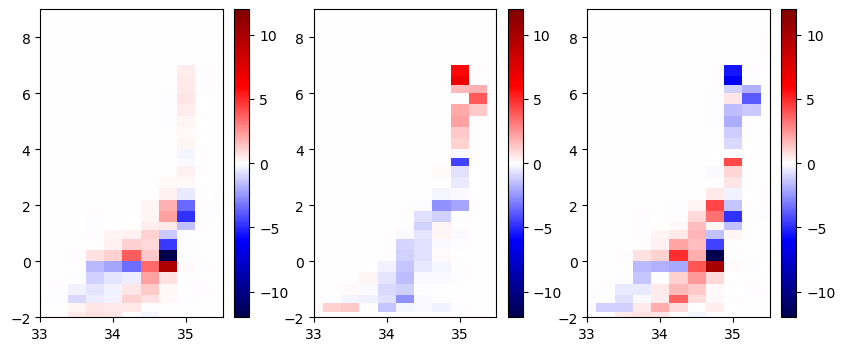

In [100]:
fig = plt.figure()

ax = plt.subplot(131)
a = div_J
b = div_Ja
cb = ax.pcolormesh(Sbin2,Tbin2,(-b),cmap="seismic",vmin=-12,vmax=12)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin2,Tbin2,(m_TS_total),cmap="seismic",vmin=-12,vmax=12)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin2,Tbin2,(-b - m_TS_total),cmap="seismic",vmin=-12,vmax=12)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

In [92]:
print(np.nansum(b))
print(np.nansum(m_TS_total))

-0.6731453510343828
5.033273146957168


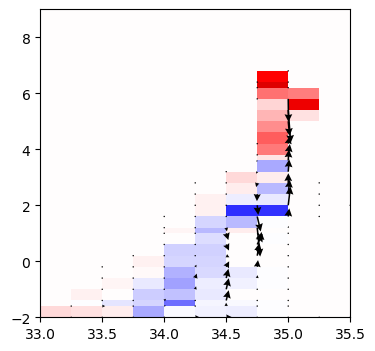

In [106]:
# plot like figure 12 in Pemberton

fig = plt.figure(figsize=(4,4))

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,(m_TS_total),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
U1,V1 = Jx_loaded[nbasin]["0000275904"]['LSto_TS'].T, Jy_loaded[nbasin]["0000275904"]['LTto_TS'].T
U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
q = ax.quiver(Sbin2, Tbin2, U1, V1, width=0.005, zorder=3, headwidth=5,scale=1e2)

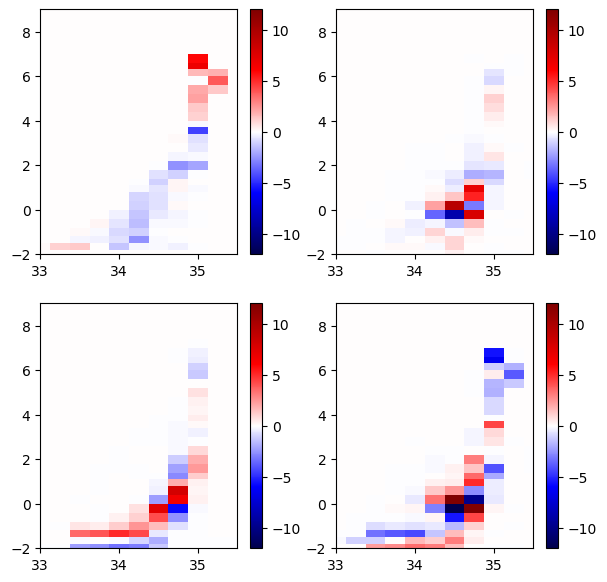

In [143]:
# plot figure 16 for this month as in Pemberton
fig = plt.figure(figsize = (7,7))

# gateway transports
ax = plt.subplot(221)
cb = ax.pcolormesh(Sbin2,Tbin2,(m_TS_total),cmap="seismic",vmin=-12,vmax=12)
plt.colorbar(cb)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)

# total divergence (total tend)
ax = plt.subplot(222)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
plt.colorbar(cb)

# divergence due to surface processes
ax = plt.subplot(223)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jsurf),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
plt.colorbar(cb)

# divergence due to internal processes
ax = plt.subplot(224)
a = m_TS_total
b = div_Ja - m_TS_total
div_Jint = -(- div_Jd - div_Ja - m_TS_total)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_Jint),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
plt.colorbar(cb)

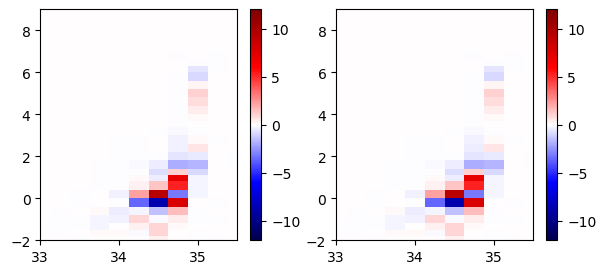

In [144]:
fig = plt.figure(figsize = (7,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin2,Tbin2,(-div_J),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin2,Tbin2,(m_TS_total - div_Jsurf - div_Jint),cmap="seismic",vmin=-12,vmax=12)
ax.set_xlim(33,35.5)
ax.set_ylim(-2,9)
plt.colorbar(cb)

# now try to create these plots for each of the months we did

In [ ]:
# load the full Jy and Jx terms

# Load the .npz file
filename = "Jy_data.npz"
filename = "Jy_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jy_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
# Jy_loaded

In [ ]:
# Define your filename
filename = "Jx_data_full.npz"
matpath = "/scratch2/mmurakami/aste_270x450x180/"
matpath += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"

# Load the .npz file
loaded_data = np.load(matpath + filename, allow_pickle=True)

# Convert it back to a dictionary
Jx_loaded = {key: loaded_data[key].item() if loaded_data[key].ndim == 0 else loaded_data[key] for key in loaded_data}
Jx_loaded[nbasin].keys()

In [ ]:
# Ensure imgpath exists

os.makedirs(imgpath, exist_ok=True)
alpha, beta = 1, 0.2
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19
arrow_length, step, t, U, scale = 0.25, 2, 0, 2, 2e1

for time in range(len(tsstr)):  # Loop through 12 time steps
    fig = plt.figure(figsize=(10, 10))
    time_idx = tsstr[time]

    # First subplot - total tendency
    ax = plt.subplot(231)
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    U1, V1 = Jx_loaded[nbasin][time_idx]['LSto_TS'].T, Jy_loaded[nbasin][time_idx]['LTto_TS'].T
    #U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
    q = ax.quiver(Sbin2, Tbin2, U1*alpha, V1*beta, width=0.005, zorder=3, headwidth=5, scale=scale)
    ax.set_xlim(32, 36)
    ax.set_ylim(-3, 12)
    ax.set_title("total tend")
    # add the quiver key and other density contours
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')
    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    ############
    # Second subplot - diff tendency
    ax = plt.subplot(232)
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    U2, V2 = (
        Jx_loaded[nbasin][time_idx]['LaSz_TS'].T + Jx_loaded[nbasin][time_idx]['LaSh_TS'].T,
        Jy_loaded[nbasin][time_idx]['LaTz_TS'].T + Jy_loaded[nbasin][time_idx]['LaTh_TS'].T
    )
    U2[U2 == 0], V2[V2 == 0] = np.nan, np.nan
    q = ax.quiver(Sbin2, Tbin2, U2*alpha, V2*beta, width=0.005, zorder=3, headwidth=5, scale=scale)
    ax.set_xlim(32, 36)
    ax.set_ylim(-3, 12)
    ax.set_title("diff tend")
    # add the quiver key and other density contours
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')
    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")
    
    ############
    # Third subplot - adv tendency
    ax = plt.subplot(233)
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    U3, V3 = (
        Jx_loaded[nbasin][time_idx]['LSza_TS'].T + Jx_loaded[nbasin][time_idx]['LSha_TS'].T,
        Jy_loaded[nbasin][time_idx]['LTza_TS'].T + Jy_loaded[nbasin][time_idx]['LTha_TS'].T
    )
    U3[U3 == 0], V3[V3 == 0] = np.nan, np.nan
    q = ax.quiver(Sbin2, Tbin2, U3*alpha, V3*beta, width=0.005, zorder=3, headwidth=5, scale=scale)
    ax.set_xlim(32, 36)
    ax.set_ylim(-3, 12)
    ax.set_title("adv tend")
    # add the quiver key and other density contours
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')
    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    ############
    # Fourth subplot - surface tendency
    ax = plt.subplot(234)
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    U4, V4 = (
        Jx_loaded[nbasin][time_idx]['LaSs_TS'].T, Jy_loaded[nbasin][time_idx]['LaTs_TS'].T
    )
    #U4[U4 == 0], V4[V4 == 0] = np.nan, np.nan
    q = ax.quiver(Sbin2, Tbin2, U4*alpha, V4*beta, width=0.005, zorder=3, headwidth=5, scale=scale)
    ax.set_xlim(32, 36)
    ax.set_ylim(-3, 12)
    ax.set_title("surf tend")
    # add the quiver key and other density contours
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')
    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    ############
    # Fifth subplot - total (calculated)
    ax = plt.subplot(235)
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    # replace nan with zero
    #U_total, V_total = (U2 + U3 + U4), (V2 + V3 + V4)
    U_total = (np.nan_to_num(U2) + np.nan_to_num(U3) + np.nan_to_num(U4))
    V_total = (np.nan_to_num(V2) + np.nan_to_num(V3) + np.nan_to_num(V4))
    U_total[U_total == 0],V_total[V_total == 0] = np.nan,np.nan

    q = ax.quiver(Sbin2, Tbin2, U_total*alpha, V_total*beta, width=0.005, zorder=3, headwidth=5, scale=scale)
    ax.set_xlim(32, 36)
    ax.set_ylim(-3, 12)
    ax.set_title("total tend (calculated)")
    # add the quiver key and other density contours
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')
    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    plt.suptitle(nbasin + " Tendencies for " + (datetimes[time] - relativedelta(months=1)).strftime("%B %Y"))

    # Save figure
    plt.savefig(os.path.join(imgpath, f"test_tendencies_{tsstr[time]}.png"), dpi=300)
    plt.close(fig)  # Close the figure to free up memory

# plotting the same convergences to see if these work

In [ ]:
# create the scaling factor for getting to Sv instead of Sv/degC or Sv/PSU
Tscale = np.flipud(np.tile(binwidthT[:,np.newaxis],(1,nT)))
Sscale = np.tile(binwidthS[np.newaxis,:],(nS,1))
Tscale = Tscale[:-1,:-1]
Sscale = Sscale[1:,:-1]

In [ ]:
# Ensure imgpath exists
os.makedirs(imgpath, exist_ok=True)
cvmin = -3
cvmax = 3

for time in range(len(tsstr)):  # Loop through 12 time steps
    fig = plt.figure(figsize=(10, 10))
    time_idx = tsstr[time]

    # First subplot - total tendency
    ax = plt.subplot(221)
    U1, V1 = Jx_loaded[nbasin][time_idx]['LSto_TS'].T, Jy_loaded[nbasin][time_idx]['LTto_TS'].T
    # Fill NaNs with 0
    U1 = np.nan_to_num(U1, nan=0.0)
    V1 = np.nan_to_num(V1, nan=0.0)
    divergence = np.gradient(U1*Tscale, axis=0) + np.gradient(V1*Sscale, axis=1)
    cb = ax.pcolormesh(Sbin2, Tbin2, -divergence,cmap='seismic',vmin=cvmin,vmax=cvmax)
    plt.colorbar(cb, ax=ax, label="Sv +: accumulation",extend="both")
    ax.set_xlim(32, 36)
    ax.set_ylim(-2.8, 12)
    ax.set_title("total tend")
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    ############
    # Second subplot - diff tendency
    ax = plt.subplot(222)
    ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    U2, V2 = (
        Jx_loaded[nbasin][time_idx]['LaSz_TS'].T + Jx_loaded[nbasin][time_idx]['LaSh_TS'].T,
        Jy_loaded[nbasin][time_idx]['LaTz_TS'].T + Jy_loaded[nbasin][time_idx]['LaTh_TS'].T
    )
    divergence = np.gradient(U2*Tscale, axis=0) + np.gradient(V2*Sscale, axis=1)
    cb = ax.pcolormesh(Sbin2, Tbin2, -divergence,cmap='seismic',vmin=cvmin,vmax=cvmax)
    plt.colorbar(cb, ax=ax, label="Sv +: accumulation",extend="both")
    ax.set_xlim(32, 36)
    ax.set_ylim(-2.8, 12)
    ax.set_title("diff tend")
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")
    
    ############
    # Third subplot - adv tendency
    ax = plt.subplot(223)
    ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib[time_idx]).T)
    U3, V3 = (
        Jx_loaded[nbasin][time_idx]['LSza_TS'].T + Jx_loaded[nbasin][time_idx]['LSha_TS'].T,
        Jy_loaded[nbasin][time_idx]['LTza_TS'].T + Jy_loaded[nbasin][time_idx]['LTha_TS'].T
    )
    divergence = np.gradient(U3*Tscale, axis=0) + np.gradient(V3*Sscale, axis=1)
    cb = ax.pcolormesh(Sbin2, Tbin2, -divergence,cmap='seismic',vmin=cvmin,vmax=cvmax)
    plt.colorbar(cb, ax=ax, label="Sv +: accumulation",extend="both")
    ax.set_xlim(32, 36)
    ax.set_ylim(-2.8, 12)
    ax.set_title("adv tend")
    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    ############
    # Fourth subplot - surface tendency
    ax = plt.subplot(224)
    U4, V4 = (
        Jx_loaded[nbasin][time_idx]['LaSs_TS'].T, Jy_loaded[nbasin][time_idx]['LaTs_TS'].T
    )
    divergence = np.gradient(U4*Tscale, axis=0) + np.gradient(V4*Sscale, axis=1)
    cb = ax.pcolormesh(Sbin2, Tbin2, -divergence,cmap='seismic',vmin=cvmin,vmax=cvmax)
    plt.colorbar(cb, ax=ax, label="Sv +: accumulation",extend="both")
    ax.set_xlim(32, 36)
    ax.set_ylim(-2.8, 12)
    ax.set_title("surf tend")
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

    plt.suptitle(nbasin + " Tendencies for " + (datetimes[time] - relativedelta(months=1)).strftime("%B %Y"))

    # Save figure
    plt.savefig(os.path.join(imgpath, f"test_convergence_{tsstr[time]}.png"), dpi=300)
    plt.close(fig)  # Close the figure to free up memory